In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import xarray as xr
import rasterio
import os



This insar notebook is used to upload data from 2009-2014 to visualise a time series. Its used for areas/points of interst and check if any change has happend around that point. This was used to make an initial plan where to take measurements with the GNSS/gravimetry/leveling campaign.

- First load the data and visualise the krafla area
- 2D timeseries
- Check timeseries of benchmarks of interest

**load data**

In [2]:
data = np.genfromtxt('TSX_UD_2009-2014.csv',delimiter=';', skip_header=1)
lon = data[:,0]
lat = data[:,1]
deformation = data[:,2]
df =  pd.DataFrame({
    'longitude': lon,
    'latitude': lat,
    'deformation': deformation
})

In [4]:
tiff_directory = '/Users/isabelslingerland/fieldlab/5_INSAR/00_DATA/TimeSeries/T9'
# List to hold the data from each TIFF file
tiff_matrices = []

# Loop through all files in the directory
for filename in os.listdir(tiff_directory):
    if filename.endswith('.tif'):
        file_path = os.path.join(tiff_directory, filename)
        with rasterio.open(file_path) as src:
            # Read the TIFF file data into an array and add it to the list
            tiff_matrices.append(src.read(1))  # 1 means first band

# # Convert the list of arrays into a 3D numpy array (if needed)
tiff_matrix = np.dstack(tiff_matrices)

print("TIFF files have been loaded into a matrix.")

TIFF files have been loaded into a matrix.


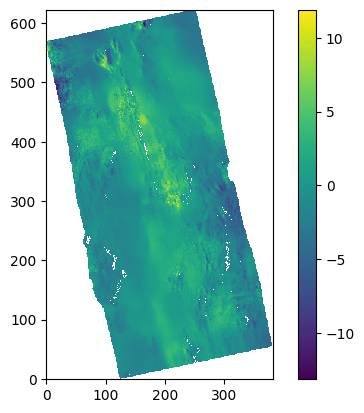

In [22]:
# visualize the first TIFF file (first slice of the 3D array)
plt.imshow(tiff_matrix[:, :, 0], origin='lower', interpolation='None')  # Change 0 to other indices to view other files
plt.colorbar()
plt.show()


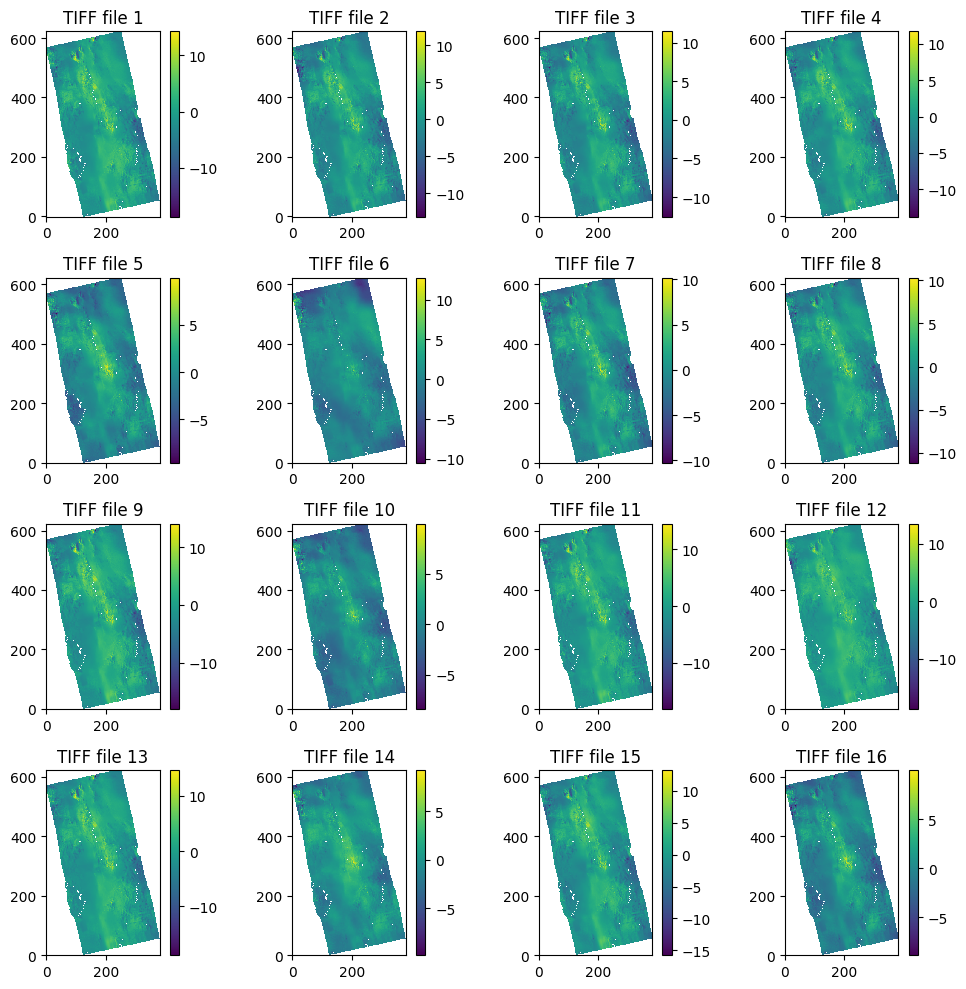

In [23]:
import matplotlib.pyplot as plt

# Set up the subplots grid
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

#Display TIFF files
for i in range(16):  
    im = axs[i].imshow(tiff_matrix[:, :, -i+1], origin='lower', interpolation='None')
    axs[i].set_title(f'TIFF file {i+1}')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()


**choose point of interest**
Check around intersted coordinates and check the Insar time series for deformation of that small region around that coordinate 

In [21]:

from rasterio.windows import from_bounds
#these are excisiting coordinates of benchmarks that we are intersted in
L595 = [65.7143157677,-16.7670989187]
KB11 = [65.7093357255,-16.7709640946]
L596 = [65.707479,-16.766925]
point= L595
# Define your region of interest bounds
#picking the pixels around the point
#left, bottom, right, top = (L595[1]-0.0008, L595[0]-0.0001, L595[1]+0.0001, L595[0]+0.0001)  # replace with your actual bounds
left, bottom, right, top = (point[1]-0.0006, point[0]-0.0006, point[1]+0.0006, point[0]+0.0006)
#left, bottom, right, top = (-lon, -lat, +lon, +lat) 


#L595: 65.714257,-16.766634,   insar(65.714563,-16.764957)
tiff_matrices = []

for filename in os.listdir(tiff_directory):
    if filename.endswith('.tif'):
        file_path = os.path.join(tiff_directory, filename)
        with rasterio.open(file_path) as src:
            # Use the bounds to create a window
            window = from_bounds(left, bottom, right, top, src.transform)
            # Read the data from the window
            tiff_data = src.read(1, window=window)
            tiff_matrices.append(tiff_data)


# # Convert the list of arrays into a 3D numpy array (if needed)
tiff_matrix = np.dstack(tiff_matrices)



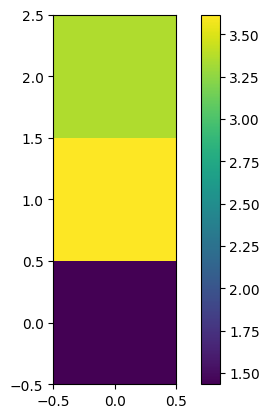

In [22]:
plt.imshow(tiff_matrix[:, :, -1], origin='lower', interpolation='None')  # Change 0 to other indices to view other files
plt.colorbar()
plt.show()


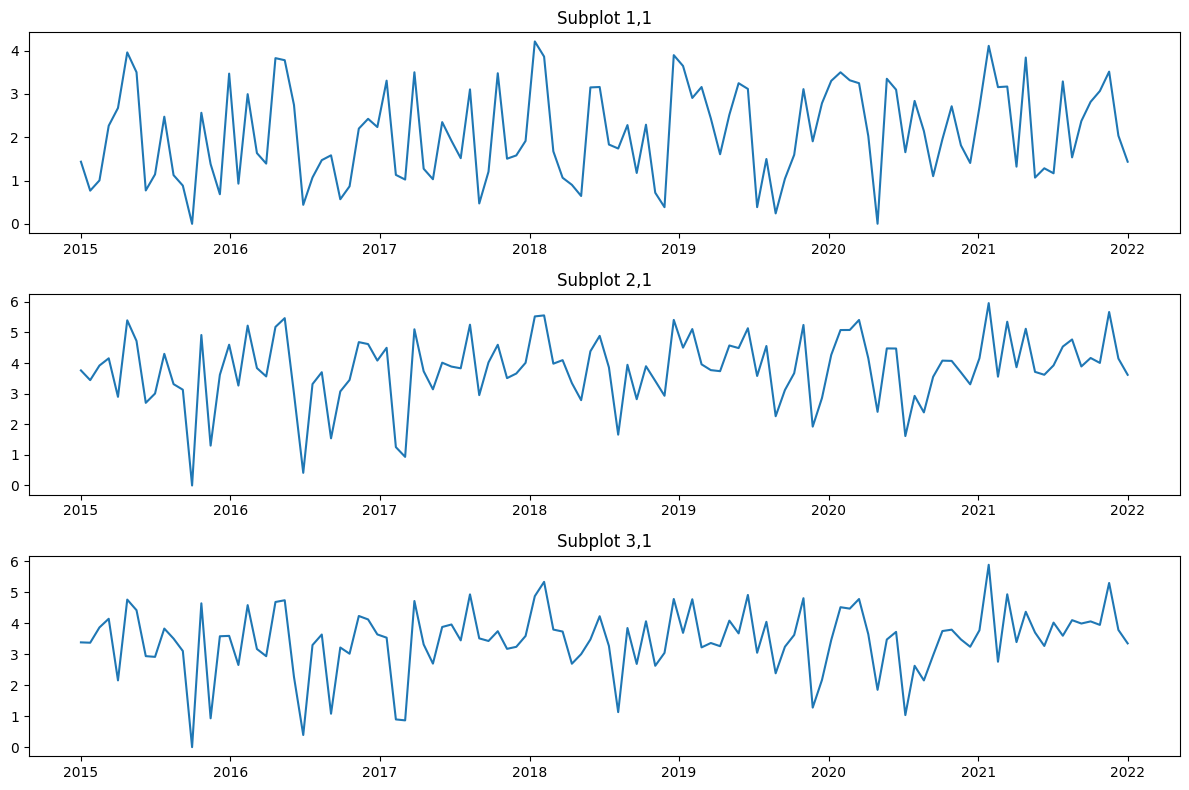

In [24]:

# If there's only one row or column, axs may not be a 2D array
time= np.linspace(2015, 2022, tiff_matrix[0,0,:].size)

# Check the shape of tiff_matrix
shape = tiff_matrix.shape
rows, cols = shape[0], shape[1]

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))
if rows == 1:
    axs = [axs]
if cols == 1:
    axs = [[ax] for ax in axs]

# Plot each slice of tiff_matrix
for i in range(rows):
    for j in range(cols):
        axs[i][j].plot(time, tiff_matrix[i, j, :])
        axs[i][j].set_title(f'Subplot {i+1},{j+1}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [25]:
def linear_squares_func(A,y):
    # linear squares form Bx_hat=C, B= A.T A , C = A.T y
    B= A.T@A
    C= A.T@y
    x_hat= np.linalg.solve(B,C)
    y_hat= A@x_hat
    residual= y_hat- y
    return x_hat, y_hat, residual



In [26]:
def build_A(time):
    """
    simple A matrix for linear regression
    time: 1D array
    """
    return np.stack((np.ones(time.size), time), axis=1)


In [28]:
A= build_A(time)
x_hat = np.zeros((tiff_matrix.shape[0], tiff_matrix.shape[1], 2))
y_hat = np.zeros(tiff_matrix.shape)
residual = np.zeros(tiff_matrix.shape)
for i in range(tiff_matrix.shape[0]):
    for j in range(tiff_matrix.shape[1]):
        x_hat[i,j,:], y_hat[i,j,:], residual[i,j,:]= linear_squares_func(A, tiff_matrix[i,j,:])
# x_hat, y_hat, residual= linear_squares_func(A, tiff_matrix[0,0,:])


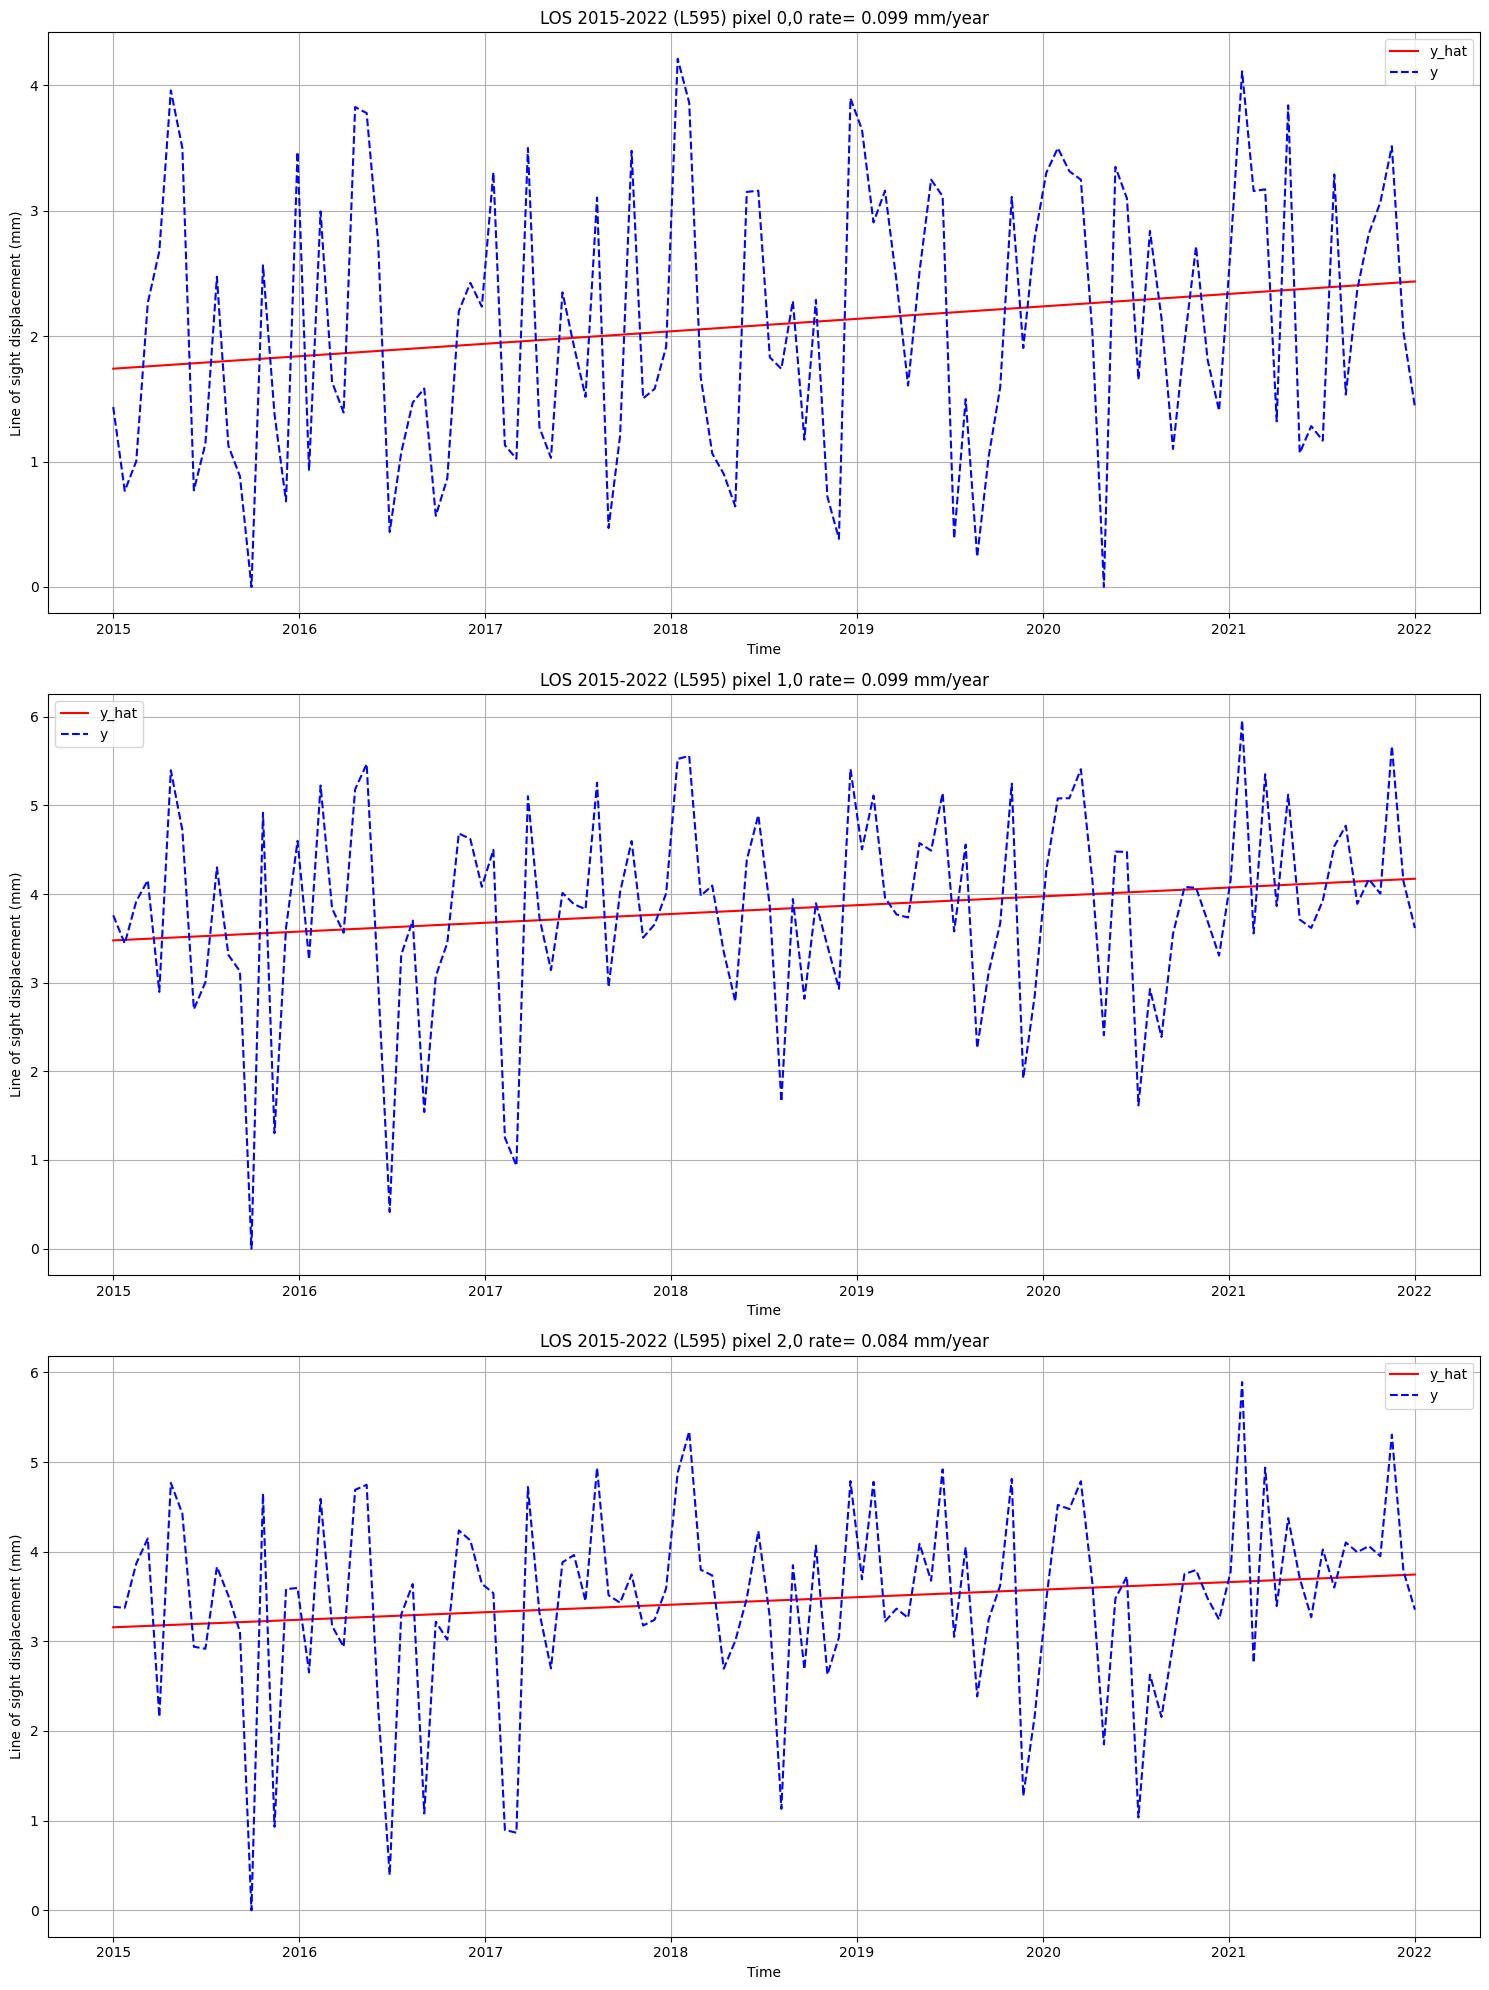

In [31]:

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

# Define the indices for the specific elements
indices = [(0, 0), (1, 0), (2, 0)]

# Plot time vs y_hat and time vs tiff_matrix for each specified element
for idx, (i, j) in enumerate(indices):
    ax1 = axes[idx]  # time vs y_hat and tiff_matrix
    
    ax1.plot(time, y_hat[i, j, :], label='y_hat', color='red')
    ax1.plot(time, tiff_matrix[i, j, :], '--', label='y', color='blue')
    ax1.set_title(f'LOS 2015-2022 (L595) pixel {i},{j} rate= {round(x_hat[i, j, 1], 3)} mm/year')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Line of sight displacement (mm)')
    ax1.legend()
    ax1.grid()

# Adjust layout
plt.tight_layout()
plt.savefig('lineofsight2015-2022tiff.png')
plt.show()

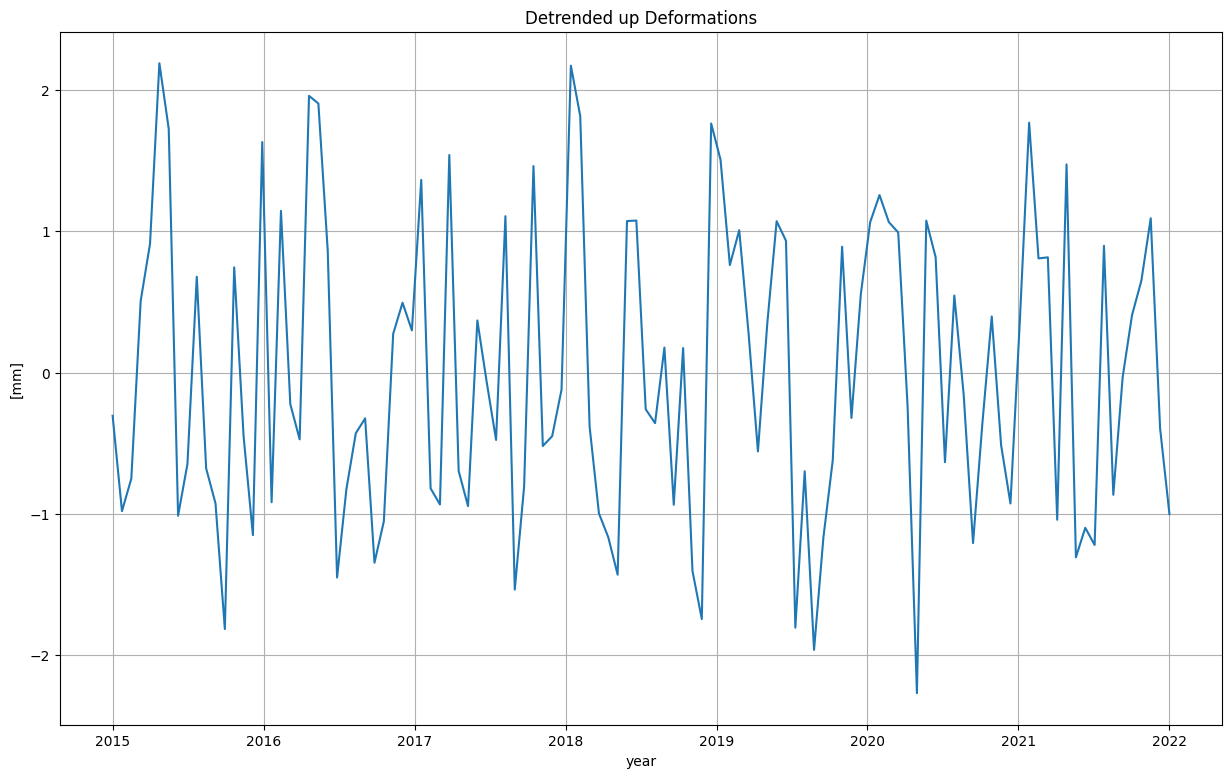

In [32]:
#detrend the data as prep for periodogram
import scipy.signal as signal
from astropy.timeseries import LombScargle

detrended_data = signal.detrend(tiff_matrix[0,0,:], axis=-1, type='linear', bp=0, overwrite_data=False)
plt.figure(figsize=(15,9))
plt.title('Detrended up Deformations')
plt.plot(time,detrended_data)
plt.ylabel('[mm]')
plt.xlabel('year')
plt.grid()

Text(0.5, 1.0, 'Lomb-Scargle periodogram of detrended time series, insar point, max peak at period 1.0 year')

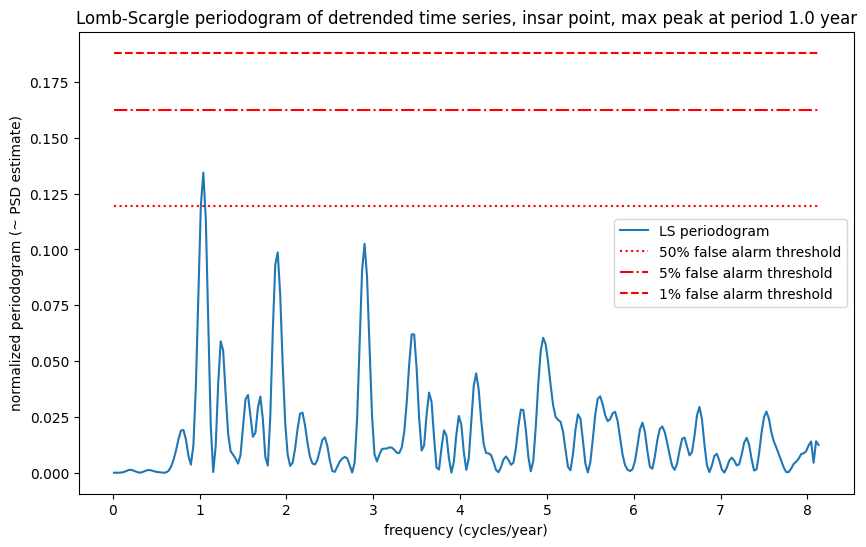

In [33]:
# perform a Lomb Scargle periodogram of the detrended data for uneven spacing


LS = LombScargle(time, detrended_data)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
#plt.xlim(0,20)
plt.ylabel('normalized periodogram (~ PSD estimate)')


freq_max = frequency[power.argmax()]
plt.title('Lomb-Scargle periodogram of detrended time series, insar point, max peak at period {} year'.format(round(1/freq_max,1)))


*** NEW insar data ***

In [34]:
data_T045_asc = xr.open_dataset('T045_asc_2018_2022.nc')


In [36]:
latitude = data_T045_asc['latitude']
longitude = data_T045_asc['longitude']
mean_velocity = data_T045_asc['mean_velocity']
# Convert latitude to a DataFrame
df_latitude = latitude.to_dataframe().reset_index()

# Convert longitude to a DataFrame
df_longitude = longitude.to_dataframe().reset_index()

df_mean_velocity = mean_velocity.to_dataframe().reset_index()

df_velocity = df_mean_velocity.merge(df_latitude, on='index') \
                       .merge(df_longitude, on='index')

In [37]:
df_velocity= df_velocity.drop(columns=['index'])
df_velocity 

,mean_velocity,latitude,longitude
0,11.0,65.499682,-16.958073
1,4.0,65.629389,-16.423608
2,8.2,65.505356,-16.588237
3,8.0,65.558171,-16.904716
4,9.3,65.716074,-16.854435
...,...,...,...
999995,5.3,65.885136,-16.420524
999996,10.4,65.752628,-17.178762
999997,7.4,65.445181,-16.662141
999998,8.9,65.649033,-16.769590


In [17]:
# # Save the DataFrame to a CSV file
# df_velocity.to_csv('velocity_data_insar_2018-2022_asc.csv', index=False)

In [38]:
# Extract the variables

latitude = data_T045_asc['latitude']
longitude = data_T045_asc['longitude']
mean_velocity = data_T045_asc['mean_velocity']

# Extract all date-specific variables
date_variables = [var for var in data_T045_asc.data_vars if var.isdigit()]
date_vars_data = [data_T045_asc[var] for var in date_variables]

# Convert latitude to a DataFrame
df_latitude = latitude.to_dataframe().reset_index()

# Convert longitude to a DataFrame
df_longitude = longitude.to_dataframe().reset_index()

df_mean_velocity = mean_velocity.to_dataframe().reset_index()

# Convert date-specific variables to DataFrames and stack them
df_date_vars = [var.to_dataframe().reset_index() for var in date_vars_data]

# Merge date-specific variables DataFrames into a single DataFrame
df_dates_combined = df_date_vars[0]
for df in df_date_vars[1:]:
    df_dates_combined = df_dates_combined.merge(df, on='index')

# Merge the DataFrames on their common dimensions (index)
df_combined = df_mean_velocity.merge(df_latitude, on='index') \
                       .merge(df_longitude, on='index') \
                       .merge(df_dates_combined, on='index')

# Display the first few rows of the combined DataFrame
print(df_combined.head())

      index  mean_velocity   latitude  longitude  20180601  20180613  \
0   5237712           11.0  65.499682 -16.958073      -0.4      -0.1   
1   8964878            4.0  65.629389 -16.423608       0.2       0.5   
2   2718953            8.2  65.505356 -16.588237      -3.9      -3.7   
3   6476009            8.0  65.558171 -16.904716      -2.3      -2.1   
4  12888236            9.3  65.716074 -16.854435       5.6       5.7   

   20180625  20180707  20180719  20180731  ...  20220710  20220722  20220803  \
0       2.8       0.4       0.5       1.6  ...      49.1      48.9      47.0   
1       4.3       2.0       3.4       0.1  ...      18.8      20.6      18.3   
2       6.7       6.7       2.1       9.0  ...      31.4      35.7      35.1   
3       3.7      -4.8       2.9       4.6  ...      35.6      35.6      36.4   
4      -2.3      -4.0      -4.2      -2.4  ...      43.4      32.9      33.1   

   20220815  20220827  20220908  20220920  20221002  20221014  20221026  
0      48.7 

In [75]:
# Specify the latitude and longitude you are interested in
specific_lat =  point[0]# Replace with the actual latitude you are looking for
specific_lon = point[1]  # Replace with the actual longitude you are looking for

# Define a tolerance value (in degrees)
tolerance = 0.001  # Adjust the tolerance as needed

# Filter rows within the bounding box around the specific latitude and longitude
regional_rows = df_combined[
    (df_combined['latitude'].between(specific_lat - tolerance, specific_lat + tolerance)) &
    (df_combined['longitude'].between(specific_lon - tolerance, specific_lon + tolerance))
]

# Display the rows within the region
print(regional_rows)
index= regional_rows.index

           index  mean_velocity   latitude  longitude  20180601  20180613  \
998415  11575721            8.1  65.713539 -16.766901      -6.0      -5.7   

        20180625  20180707  20180719  20180731  ...  20220710  20220722  \
998415       6.4      10.2       7.4       6.2  ...      33.5      34.9   

        20220803  20220815  20220827  20220908  20220920  20221002  20221014  \
998415      33.6      30.7      37.4      38.4      38.7      38.0      40.2   

        20221026  
998415      39.7  

[1 rows x 69 columns]


In [76]:
selected_pixel = df_combined.iloc[index,4:]

In [72]:
lat1= df_combined.iloc[index[0],2]
lon1= df_combined.iloc[index[0],3]
lat2= df_combined.iloc[index[1],2]
lon2= df_combined.iloc[index[2],3]
lat3= df_combined.iloc[index[3],2]
print(lat,lon, point)

65.713162 -16.766872 [65.7143157677, -16.7670989187]


In [78]:
print(selected_pixel.shape)
selected_pixel_matrix = selected_pixel.to_numpy()

(1, 65)


In [83]:
print(selected_pixel_matrix.shape)
time= np.linspace(2018, 2022, selected_pixel_matrix.size)
print(time.shape)


(1, 65)
(65,)


In [84]:
A= build_A(time)


x_hat_2018_2022, y_hat_2018_2022, residual_2018_2022= linear_squares_func(A, selected_pixel_matrix[0,:])



In [66]:
y_hat.shape

(4, 65)

Text(0.5, 1.0, 'LOS 2018-2022 asc rate= 10mm/year')

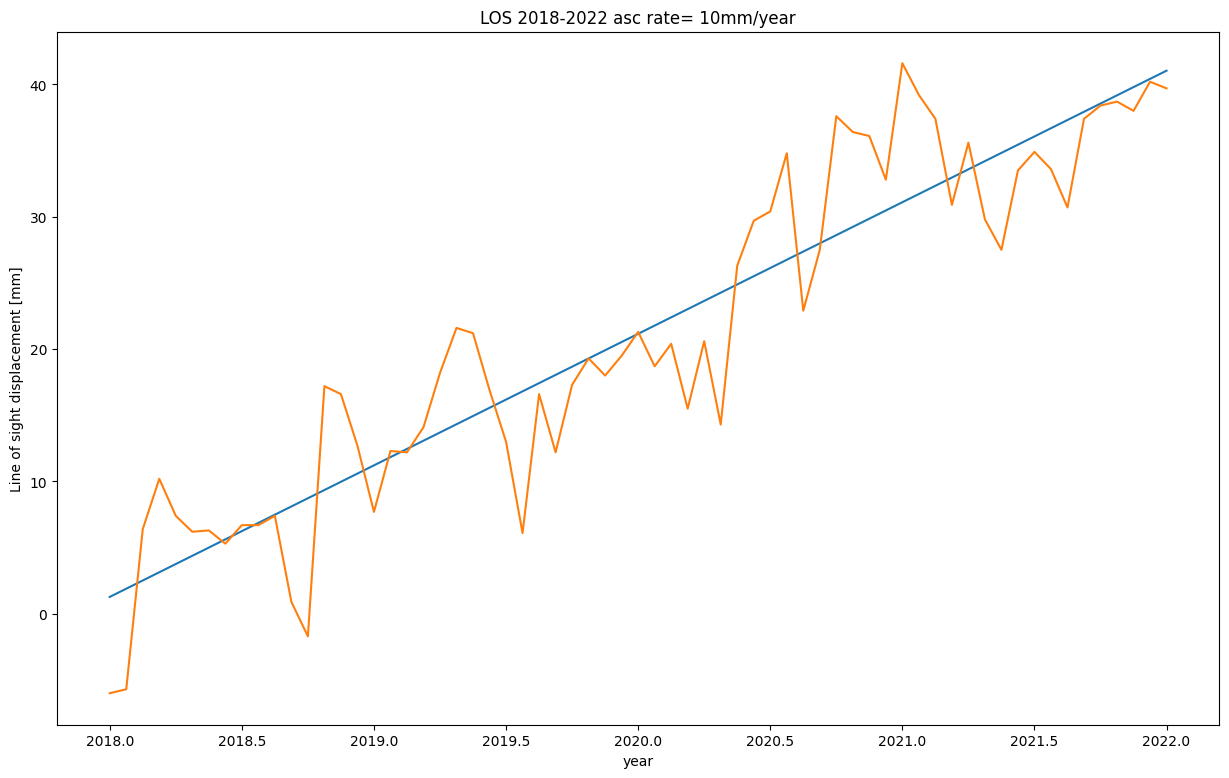

In [87]:
plt.figure(figsize=(15,9))
plt.plot(time,y_hat_2018_2022)
plt.plot(time,selected_pixel_matrix[0,:])
plt.ylabel('Line of sight displacement [mm]')
plt.xlabel('year')
plt.title(f'LOS 2018-2022 asc rate= {round(x_hat_2018_2022[1])}mm/year'.format(round(x_hat_2018_2022[1],3)))

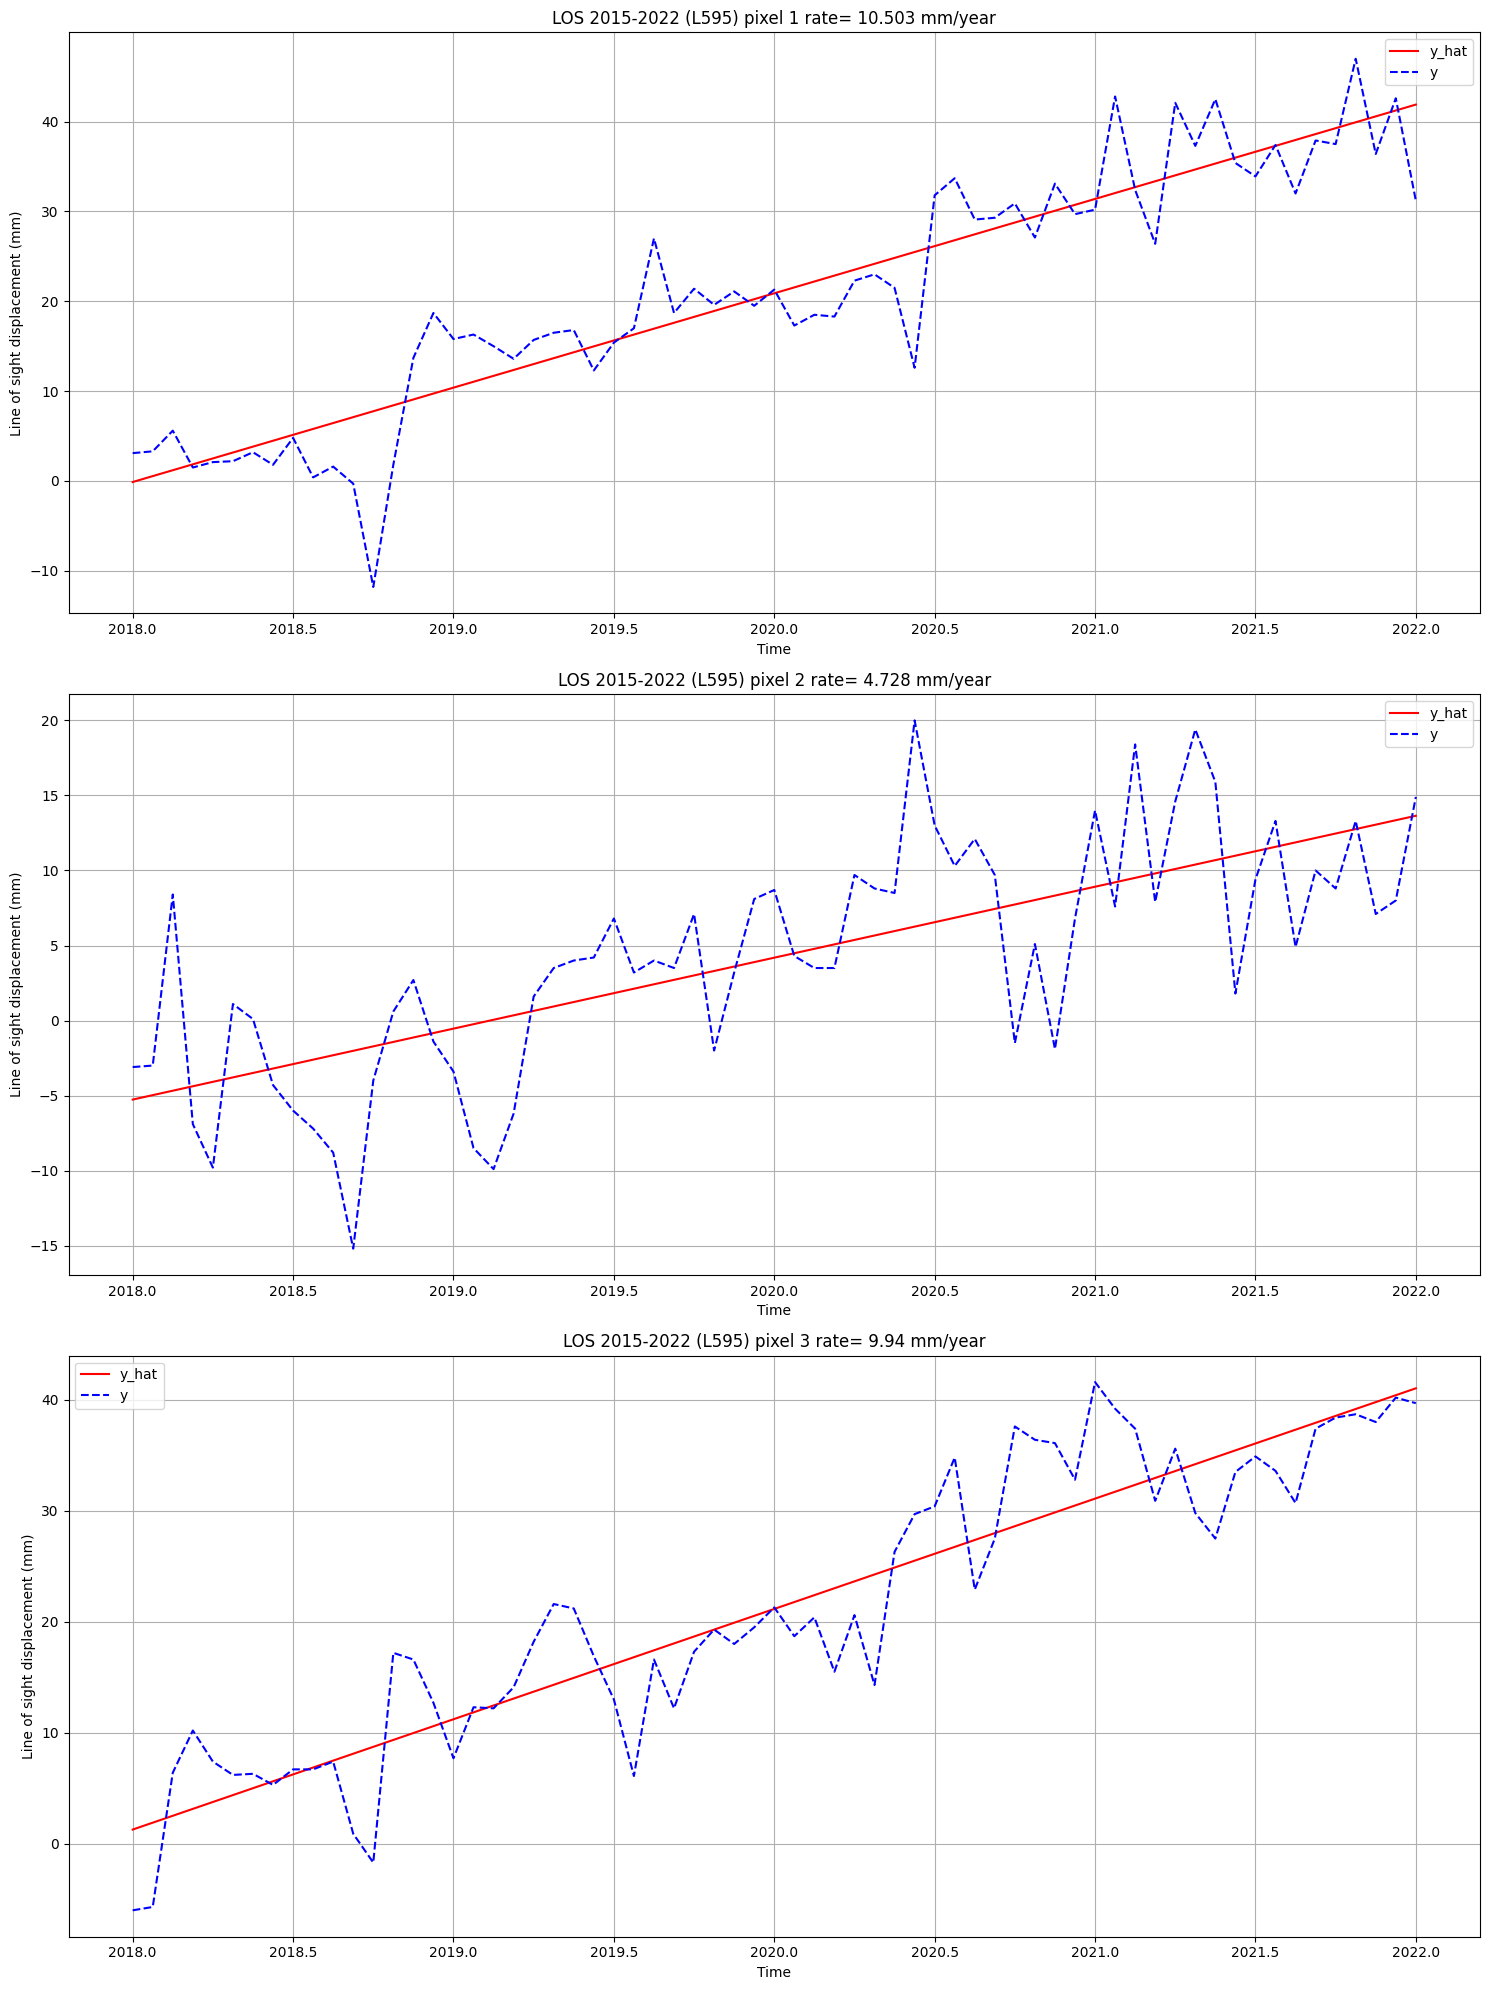

In [74]:

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 20)) 



# Plot time vs y_hat and time vs tiff_mtrix for each specified element
for i in range(3):
    ax1 = axes[i]  # Access the corresponding subplot
    
    ax1.plot(time, y_hat[i+1, :], label='y_hat', color='red')
    ax1.plot(time, selected_pixel_matrix[i+1, :], '--', label='y', color='blue')
    ax1.set_title(f'LOS 2015-2022 (L595) pixel {i+1} rate= {round(x_hat[i+1, 1], 3)} mm/year')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Line of sight displacement (mm)')
    ax1.legend()
    ax1.grid()

# Adjust layout
plt.tight_layout()
plt.savefig('lineofsight2018-2022-nc.png')
plt.show()

